In [6]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = True



In [7]:
import sys 
import os
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../VasModules')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver


saveFigs = False

In [8]:
from transforms import transforms
from Decon import SpectralDecon
from synthData_Gen import SyntheticData_Gen

#### Load data

In [13]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = np.asarray(data_d18O_LT['depth'])
d18O_LT = np.asarray(data_d18O_LT['d18O'])

#plt.plot(depth_LT,d18O_LT)
depthDif = np.diff(depth_LT)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-13-00433bd71540>:16: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


# Unevenly sampled data

#### Define interpolation function

In [14]:
def interpData(d_in, x_in, DeltaInput=False, DeltaIn=0.):
    
    d = d_in
    x = x_in
    
    if DeltaInput:
        Delta = DeltaIn
    else:
        diff = np.diff(d)
        Delta = round(min(diff), 3)

    d_min = Delta * np.ceil(d[0]/Delta)
    d_max = Delta * np.floor(d[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)

    j_arr = np.linspace(0,n,n)
    dhat0 = d_min + (j_arr - 1)*Delta

    f = interpolate.CubicSpline(d,x)

    xhat0 = f(dhat0)

    dhat = dhat0[(dhat0 >= min(d_in)) & (dhat0 <= max(d_in))]
    xhat = xhat0[(dhat0 >= min(d_in)) & (dhat0 <= max(d_in))]

    return dhat, xhat, Delta

### Interpolation BF decon

#### Interpolate chosen data with four different resampling sizes

In [15]:
d, x, delta = interpData(depth_LT, d18O_LT)
d1, x1, delta1 = interpData(depth_LT, d18O_LT, True, 0.02)
d2, x2, delta2 = interpData(depth_LT, d18O_LT, True, 0.1)
d3, x3, delta3 = interpData(depth_LT, d18O_LT, True, 0.2)

#### Plot the OG data along with the resampled signal, $\Delta = 3.80$  

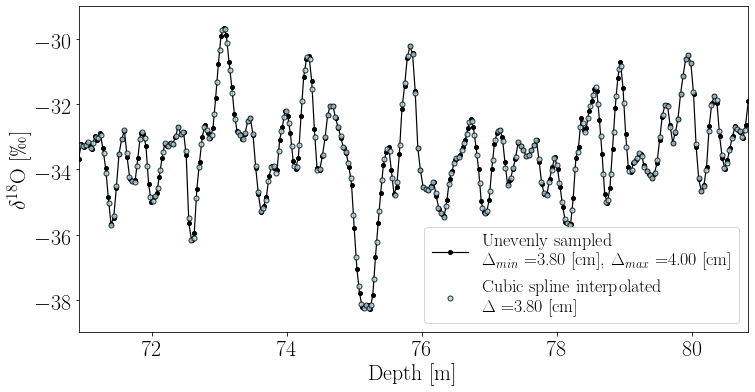

In [16]:
fig, ax = plt.subplots(figsize=(12,6))


ax.plot(depth_LT, d18O_LT, '-', marker='.', ms=8, lw=1.2, c='k', label='Unevenly sampled\n$\Delta_{min} = $' + f'{min(depthDif)*100:.2f} [cm]'+', $\Delta_{max} = $' + f'{max(depthDif)*100:.2f} [cm]')
ax.plot(d, x, '.', marker='.', markeredgecolor='k', ms=10,lw=1.2, label=f'Cubic spline interpolated\n$\Delta = ${delta*100:.2f} [cm]', c='lightblue', alpha=0.8)
ax.set(xlim=(min(depth_LT), max(depth_LT)), ylim=(-39,-29), xlabel='Depth [m]', ylabel='$\delta^{18}$O [$\permil$]')
ax.legend(fontsize=18)

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+site+'_DataSplineInterp.pdf', bbox_inches='tight')

In [17]:
saveFigs = True

#### Plot the four different resamples

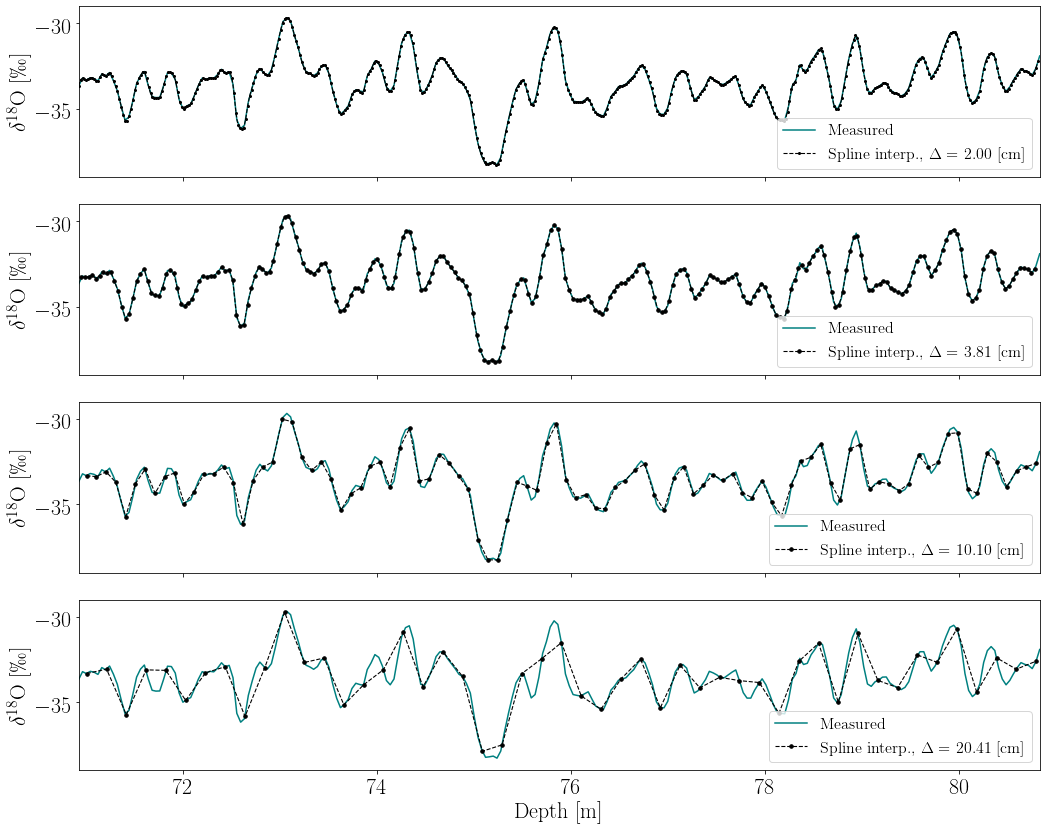

In [20]:
fig, ax = plt.subplots(4,1,figsize=(15,12), sharex=True)

ax[0].plot(depth_LT, d18O_LT, '-', lw=1.5, c='teal', label='Measured')
ax[0].plot(d1, x1, '--', marker='.', c='k', ms=4, lw=1.1, label=f'Spline interp., $\Delta = $ {(d1[1]-d1[0])*100:.2f} [cm]')

ax[1].plot(depth_LT, d18O_LT, '-', lw=1.5, c='teal', label='Measured')
#ax.plot(d, x, '.', marker='.', markeredgecolor='k', ms=10,lw=1.2, label=f'Cubic spline interpolated\n$\Delta = ${delta*100:.2f} [cm]', c='blue', alpha=0.8)
ax[1].plot(d, x, '--', marker='.', c='k', lw=1.1, ms=7, label=f'Spline interp., $\Delta = $ {(d[1]-d[0])*100:.2f} [cm]')

ax[2].plot(depth_LT, d18O_LT, '-', lw=1.5, c='teal', label='Measured')
ax[2].plot(d2, x2, '--', marker='.', c='k', lw=1.1, ms=7, label=f'Spline interp., $\Delta = $ {(d2[1]-d2[0])*100:.2f} [cm]')

ax[3].plot(depth_LT, d18O_LT, '-', lw=1.5, c='teal', label='Measured')
ax[3].plot(d3, x3, '--', marker='.', c='k',lw=1.1, ms=7, label=f'Spline interp., $\Delta = $ {(d3[1]-d3[0])*100:.2f} [cm]')
ax[3].set(xlabel='Depth [m]')
for i in range(4):
    ax[i].set(xlim=(min(depth_LT), max(depth_LT)), ylim=(-39,-29), ylabel='$\delta^{18}$O [$\permil$]')
    ax[i].legend(fontsize=16)
#ax.legend(fontsize=18)
fig.tight_layout()
if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+site+'_MultiSplineInterp.pdf', bbox_inches='tight')

#### Create back diffusion instance and compute diffusion length estimates based on different resampling sizes.

In [93]:
#from StabilityTests import getInterpBFdata, getDiffLen_V_Npeaks, getInterpAFdata

In [97]:
#delta_arr = np.linspace(0.022,0.12,100)

In [98]:
#getInterpBFdata(site_in=site, delta_arr_in=delta_arr, yrsInSec=33, interpType='CubicSpline')


Run 0
Delta: 0.022

Sigma fit: 5.85
Min sigma analyt: 7.69
Starting sigma: 3.85 [cm]
Final sigma: 3.66 [cm]
Final # of peaks: 32
Delta: 0.022
Delta new: 0.022

Run 1
Delta: 0.023

Sigma fit: 6.10
Min sigma analyt: 7.69
Starting sigma: 4.10 [cm]
Final sigma: 4.05 [cm]
Final # of peaks: 32
Delta: 0.023
Delta new: 0.023

Run 2
Delta: 0.024

Sigma fit: 6.28
Min sigma analyt: 7.69
Starting sigma: 4.28 [cm]
Final sigma: 4.27 [cm]
Final # of peaks: 32
Delta: 0.024
Delta new: 0.024

Run 3
Delta: 0.025

Sigma fit: 5.95
Min sigma analyt: 7.69
Starting sigma: 3.95 [cm]
Final sigma: 3.68 [cm]
Final # of peaks: 33
Delta: 0.025
Delta new: 0.025

Run 4
Delta: 0.026

Sigma fit: 5.28
Min sigma analyt: 7.69
Starting sigma: 3.28 [cm]
Final sigma: 3.19 [cm]
Final # of peaks: 32
Delta: 0.026
Delta new: 0.026

Run 5
Delta: 0.027

Sigma fit: 6.01
Min sigma analyt: 7.69
Starting sigma: 4.01 [cm]
Final sigma: 3.72 [cm]
Final # of peaks: 32
Delta: 0.027
Delta new: 0.027

Run 6
Delta: 0.028

Sigma fit: 6.35
Min

100. Npeaks: 32, diffLen: 6.693 cm
200. Npeaks: 33, diffLen: 7.696 cm
Final sigma: 8.52 [cm]
Final # of peaks: 33
Delta: 0.067
Delta new: 0.067

Run 46
Delta: 0.068

Sigma fit: 7.69
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
100. Npeaks: 33, diffLen: 6.689 cm
Final sigma: 7.26 [cm]
Final # of peaks: 33
Delta: 0.068
Delta new: 0.068

Run 47
Delta: 0.069

Sigma fit: 7.42
Min sigma analyt: 7.69
Starting sigma: 5.42 [cm]
Final sigma: 6.25 [cm]
Final # of peaks: 33
Delta: 0.069
Delta new: 0.069

Run 48
Delta: 0.070

Sigma fit: 7.86
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
100. Npeaks: 32, diffLen: 6.693 cm
200. Npeaks: 33, diffLen: 7.695 cm
Final sigma: 8.01 [cm]
Final # of peaks: 33
Delta: 0.071
Delta new: 0.071

Run 49
Delta: 0.071

Sigma fit: 7.96
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
100. Npeaks: 32, diffLen: 6.693 cm
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.072
Delta new: 0.072

Run 50
Delta: 0.071

Sigma fit: 7.52
Min sigma analyt: 7.69
Starting si

Sigma fit: 7.39
Min sigma analyt: 7.69
Starting sigma: 5.39 [cm]
100. Npeaks: 29, diffLen: 6.390 cm
200. Npeaks: 30, diffLen: 7.395 cm
300. Npeaks: 32, diffLen: 8.400 cm
Final sigma: 8.92 [cm]
Final # of peaks: 33
Delta: 0.102
Delta new: 0.102

Run 81
Delta: 0.102

Sigma fit: 8.58
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
100. Npeaks: 28, diffLen: 6.693 cm
200. Npeaks: 30, diffLen: 7.698 cm
300. Npeaks: 30, diffLen: 8.703 cm
400. Npeaks: 32, diffLen: 9.708 cm
Final sigma: 9.97 [cm]
Final # of peaks: 33
Delta: 0.103
Delta new: 0.103

Run 82
Delta: 0.103

Sigma fit: 8.02
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
100. Npeaks: 30, diffLen: 6.693 cm
200. Npeaks: 31, diffLen: 7.698 cm
300. Npeaks: 31, diffLen: 8.703 cm
400. Npeaks: 33, diffLen: 9.708 cm
Final sigma: 10.34 [cm]
Final # of peaks: 33
Delta: 0.104
Delta new: 0.104

Run 83
Delta: 0.104

Sigma fit: 7.44
Min sigma analyt: 7.69
Starting sigma: 5.44 [cm]
100. Npeaks: 29, diffLen: 6.443 cm
200. Npeaks: 30, diffLen: 7.448

FileNotFoundError: [Errno 2] No such file or directory: '../Data/SiteA_DiffLensVdelta_InterpBF.txt'

In [ ]:
# CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
#
# coreNames = CoresSpecs['CoreName']
#
# sites = ['Crete', 'SiteA','SiteB', 'SiteE', 'SiteG']
# deltaMins = [0.02,0.022,0.01,0.02,0.02]
# deltaMaxs = [0.13,0.12,0.14,0.12,0.11]
# yrs = [32,32,33,32,32]
#
# i = 0
# for i in range(0,len(sites)):
#     print('\n\n\n###############')
#     print('#### ' + sites[i] + ' ####')
#     print('###############')
    #     delta_arr = np.linspace(deltaMins[i],deltaMaxs[i],100)
#     getInterpBFdata(site_in=sites[i], delta_arr_in=delta_arr,yrsInSec=yrs[i])
#     i += 1

### Interpolation AF decon

#### Load core data and specifications and define all data of interest.

#### Choose core.

In [84]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


site = 'SiteG'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


#### Define interpolation size array from high resoultion to low resolution.
#### create empty lists to store data in.

In [85]:
delta_arr = np.arange(0.01,0.11,0.04)
diffLens = []
depths = []
datas = []
peakss = [] 
delta_arr

array([0.01, 0.05, 0.09])

#### Define instance of back diffusion class for data from specific site.

In [89]:
inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, 33, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depthOG, dataOG, diffLenOG, peaksOG, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.01)


Sigma fit: 8.08
Min sigma analyt: 8.85
Starting sigma: 6.08 [cm]
100. Npeaks: 29, diffLen: 7.085 cm
200. Npeaks: 32, diffLen: 8.090 cm
Final sigma: 8.89 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040


#### For all sampling sizes (deltas) compute diffusion length resulting in 32 peaks.

In [91]:
for i in range(len(delta_arr)):
    print('\n')
    depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True, newDelta=delta_arr[i])
    depths.append(depth1)
    datas.append(data)
    peakss.append(peaks)
    diffLens.append(diffLen)




Sigma fit: 8.08
Min sigma analyt: 8.85
Starting sigma: 6.08 [cm]
100. Npeaks: 31, diffLen: 7.085 cm
200. Npeaks: 32, diffLen: 8.090 cm
Final sigma: 8.75 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.010


Sigma fit: 8.08
Min sigma analyt: 8.85
Starting sigma: 6.08 [cm]
100. Npeaks: 29, diffLen: 7.085 cm
200. Npeaks: 32, diffLen: 8.090 cm
Final sigma: 8.97 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.050


Sigma fit: 8.08
Min sigma analyt: 8.85
Starting sigma: 6.08 [cm]
100. Npeaks: 27, diffLen: 7.085 cm
200. Npeaks: 30, diffLen: 8.090 cm
300. Npeaks: 33, diffLen: 9.094 cm
Final sigma: 9.97 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.091


#### Plot 4 instances of resampling

In [ ]:
fig, ax = plt.subplots(len(delta_arr),1,figsize=(15,14),sharex=True)
colors = ['teal','teal','teal']
for i in range(len(delta_arr)):#,len(delta_arr)):
    #ax[i].plot(depthOG,dataOG, '-', marker='', label=f'$\sigma$ = {diffLenOG*100:.2f} [cm], s = 4 [cm]', lw=1.2, color='k',alpha=0.8)

    depth = depths[i]
    data = datas[i]
    ax[i].plot(depth,data, '-', marker='.', label=f'$\sigma$ = {diffLens[i]*100:.2f} [cm], s = {delta_arr[i]*100} [cm]', lw=1.2, color=colors[i], alpha=0.95, ms=5)
    ax[i].set(xlim=(min(depth),max(depth)), ylabel='$\delta^{18}$O (detrended) [\permil]')
    ax[i].plot(depth[peakss[i]],data[peakss[i]],'.', color='maroon', ms=10, label=f'Peaks, N = {len(peakss[i])}')
    
    ax[i].legend(fontsize=16)
    ax[i].plot(data_d18O_LT['depth'], data_d18O_LT['d18O']- np.mean(data_d18O_LT['d18O']),ls='--',label=f'Data, s = 4 [cm]', color='k', lw=1.2, alpha=0.8)
ax[-1].set(xlabel='Depth [m]')
fig.tight_layout()


if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+site+'_InterpAF_4samplings.png', bbox_inches='tight')

#### Plot in same figure

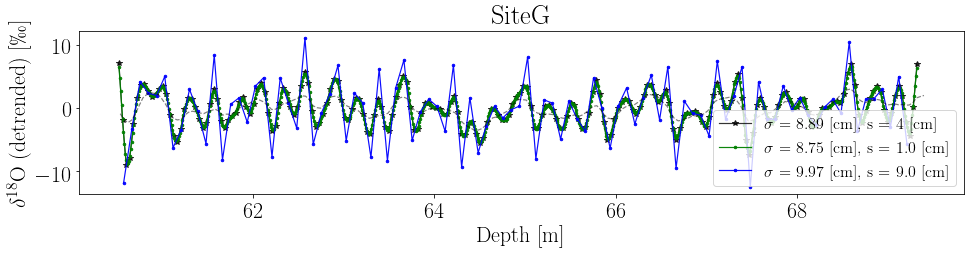

In [92]:

fig, ax = plt.subplots(figsize=(14,4))
colors = ['green','darkgreen','blue']
ax.plot(depthOG,dataOG, '-', marker='*', label=f'$\sigma$ = {diffLenOG*100:.2f} [cm], s = 4 [cm]', lw=1.2, color='k',alpha=0.8)
for i in [0,2]:#,len(delta_arr)):
    depth = depths[i]
    data = datas[i]
    ax.plot(depth,data, '-', marker='.', label=f'$\sigma$ = {diffLens[i]*100:.2f} [cm], s = {delta_arr[i]*100} [cm]', lw=1.2, color=colors[i], alpha=0.95, ms=5)
    #ax.plot(depth[peakss[i]],data[peakss[i]],'.', color='maroon', ms=10, label=f'Peaks, N = {len(peakss[i])}')
ax.set(title=site, xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]')
ax.legend(fontsize=16)
ax.plot(data_d18O_LT['depth'], data_d18O_LT['d18O']- np.mean(data_d18O_LT['d18O']),ls='--',label=f'Data, s = 4 [cm]', color='k', lw=1.2, alpha=0.5)

fig.tight_layout()
#fig.savefig('../WrittenWork/Figures/'+site+'ResampledAFDecon1And9cm.jpg', bbox_inches='tight')

#### Then, check sampling size v. diffusion length giving N = 33 peaks

In [ ]:
# CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
#
# coreNames = CoresSpecs['CoreName']
#
# sites = ['SiteA', 'SiteB', 'SiteE', 'SiteG']
# delta_arr = np.arange(0.01,0.075,0.0005)
#
# for site in sites:
#     print('\n\n\n###############')
#     print('#### ' + site + ' ####')
#     print('###############')
#     getInterpAFdata(site_in=site, delta_arr_in=delta_arr)


In [ ]:
sites = ['Crete', 'SiteA', 'SiteB', 'SiteE', 'SiteG']
delta0s = [0.026, 0.038, 0.038, 0.041, 0.040]

colors = ['darkred','teal','darkgreen','maroon','navy']
fig,axes = plt.subplots(3,2,figsize=(14,10))#, sharex=True)#, sharey=True)

i = 0
for site, ax in zip(sites,axes.flatten()):
    Site = pd.read_csv('../Data/'+site + '_DiffLensVdelta.txt', sep='\t')

    DiffLens = Site['diffLens']
    Deltas = Site['deltas']
    ax.plot(Deltas*100, DiffLens*100,'.', marker='.', ms=5, lw=1.2, label=site, color=colors[i])
    ax.plot(Deltas*100, DiffLens*100,'-', lw=1.2,  alpha=0.8, color=colors[i],label='')
    ax.axvline(x=delta0s[i]*100, color='k',ls='--', lw=1.3, alpha=0.8, label=f'$\Delta$ = {delta0s[i]*100:.2f}')
    ax.axvline(x=(delta0s[i]/2)*100, color='b',ls='--', lw=1.3, alpha=0.8, label=f'$\Delta$/2 = {(delta0s[i]/2)*100:.2f}')
    ax.set(ylabel='Diffusion length [cm]', xlabel='Sampling size [cm]')
    ax.legend(fontsize=16)
    i+=1
    
fig.tight_layout()

#fig.savefig('../WrittenWork/Figures/SamlingVsDiffLen.jpg', bbox_inches='tight')

# Monomials

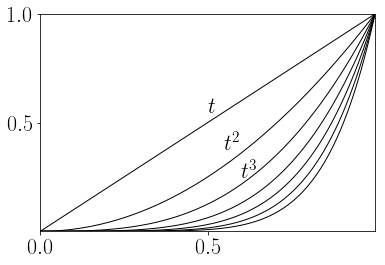

In [112]:
t = np.linspace(0,1,1000)


monoms = 8


fig, ax = plt.subplots(figsize=(6,4))
ax.set(xlim=(0,1), ylim=(0,1))
ax.text(0.5,0.55,'$t$')
ax.text(0.55,0.38,'$t^{2}$')
ax.text(0.6,0.25,'$t^{3}$')

plt.xticks(np.arange(0, 1, step=0.5)) 
plt.yticks(np.arange(0.5, 1.1, step=0.5)) 
for i in range(1,monoms):
    plt.plot(t,t**i,lw=1,c='k')
    
    
if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'Monomials.png', bbox_inches='tight')

# Peak Detection

In [9]:
sites = ['B19','B22','B23','SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInts = [33, 33, 33, 33, 33, 33]
Nt_InInts = [33, 33, 33, 33, 33, 33]

j = -1

site = sites[j]
N_InInt = N_InInts[j]

N_InInt_test = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth'][1:]
d18O = data_d18O['d18O'][1:]
depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

depthECM = data_ECM['depth']
ECM = data_ECM['ECM']
depthECM_LT = data_ECM_LT['depth']
ECM_LT = data_ECM_LT['ECM']


No ECM file found, setting empty df instead


<ipython-input-9-db69290d4ef2>:25: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'


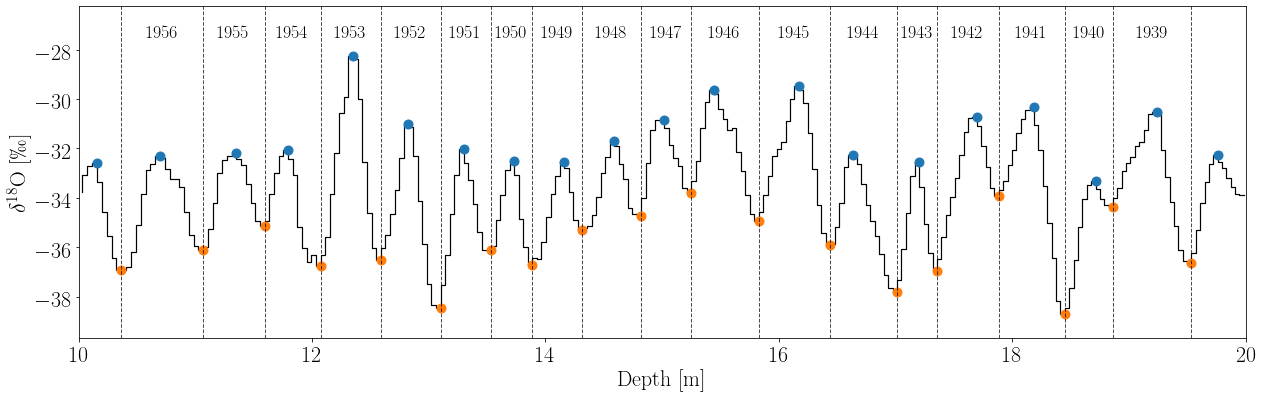

In [12]:
top_min = 10
top_max = 20
depth_top = np.asarray(depth[(depth > top_min) & (depth < top_max)])
d18O_top = np.asarray(d18O[(depth > top_min) & (depth < top_max)])
troughs = signal.find_peaks(-d18O_top, distance=7)[0]
peaks = signal.find_peaks(d18O_top, distance=7)[0]
yrs = np.linspace(1956,1939,1956-1939+1, dtype=int)
xs = depth_top[troughs][:-1] + np.diff(depth_top[troughs])/2

fig, ax = plt.subplots(figsize=(18,6))

ax.step(depth_top,d18O_top, lw=1.2, c='k')
ax.set(xlim=(top_min,top_max), ylabel='$\delta^{18}$O [$\permil$]', xlabel='Depth [m]', ylim=(min(d18O_top)-1, max(d18O_top)+2));
ax.plot(depth_top[peaks],d18O_top[peaks],'.', ms=18)
ax.plot(depth_top[troughs],d18O_top[troughs],'.', ms=18)
for i in range(len(troughs)):
    ax.axvline(depth_top[troughs[i]], c='k', ls='--', lw=1, alpha=0.7)
    if i < len(yrs):
        ax.text(xs[i],-27.5, yrs[i], fontsize=18, ha='center')

fig.tight_layout()

saveFigs = True
if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'Crete_10m_PeaksTroughs.pdf', bbox_inches='tight')